## <center>A/B test Privacy, and Online Regression</center>

A/B test or randomized controlled trials is a technique to understand and analize the effect of some events or treatments are true. So to perform this A/B test will need to get two groups random build where one of them is the control group , possible apllying placebo, and the second apply the event or the treatment. The idea of this test, is to calculate if the difference of the groups are for chance or really the event or the treatment works. Therefore first we should stablish a Hypothesis H0, where assume there is no difference and Hypothesis H1 where supposed the difference is true and due to the event or the treatment.
The inference statistics comes to help us, with a lot of theory and different type of tools depending of which kind of variables we are working on and the relationship between them and python that makes our life easier to offer libraries with all of this test ready to use.

This example is taken from Matteo Courthoud and modify a little to accomplish the assumtions of the t-test, to perform a regression and random forest using random grid to get the best parameters.

A Simple Example

Suppose we were a fin-tech company. We have designed a new user interface (UI) for our mobile application and we would like to understand whether it slows down our transactions. In order to estimate the causal effect of the new UI on transaction speed, we plan to run an A/B test or randomized controlled trial: we split users into two groups at random, to one group we show the new UI, and we compare the average transaction speed across the two groups.

First, let’s have a look at the data. I used the jupiter notebbok of https://github.com/matteocourthoud to recreate and modify the analysis.

## Table of Contents

1. <a href="#item1">Generate, explore and plot the data</a>
2. <a href="#item2">Checking the assumptions</a>  
3. <a href="#item3">Linear regression model</a>  
4. <a href="#item4">Random Forest model</a>  
5. <a href="#item5">Conclusions</a> 

<a id="item1"></a>

### 1.- Generate, explore and plot the data

In [1]:
# First import some libraries

import numpy as np
import scipy as sp
import pandas as pd

print("Libraries imported!!!")

Libraries imported!!!


In [2]:
# Generate the data that we will use.

class dgp_credit():
    """
    Data Generating Process: credit cards
    """

    def generate_data(self, N = 100, seed=0):
        np.random.seed(seed)
        
        # Connection speed
        connection = np.random.lognormal(3, 1, N)
        
        # Treatment assignment
        newUI = np.random.binomial(1, 0.5, N)
        
        # Transfer speed
        #transfer = np.minimum(np.random.exponential(10 + 4*newUI - 0.5*np.sqrt(connection), N), connection)
        transfer = np.minimum(np.random.lognormal(2.8 + newUI, 1, N), connection)
        
        # Generate the dataframe
        df = pd.DataFrame({'newUI': newUI,  
                           'connection': np.round(connection,2), 
                           'transfer': np.round(transfer,2)})

        return df

First, I generate the whole dataset to analize it.

In [3]:
N = 100
df = dgp_credit.generate_data(N)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   newUI       100 non-null    int32  
 1   connection  100 non-null    float64
 2   transfer    100 non-null    float64
dtypes: float64(2), int32(1)
memory usage: 2.1 KB


In [4]:
df[df['newUI'] == 1].describe()

,newUI,connection,transfer
count,51.0,51.000000,51.000000
mean,1.0,36.809412,23.661961
std,0.0,40.720196,30.638574
min,1.0,1.560000,1.560000
25%,1.0,9.235000,8.710000
50%,1.0,22.680000,14.020000
75%,1.0,42.315000,27.765000
max,1.0,194.370000,194.370000


In [5]:
df[df['newUI'] == 0].describe()

,newUI,connection,transfer
count,49.0,49.000000,49.000000
mean,0.0,32.778571,14.053265
std,0.0,36.199891,11.026545
min,0.0,3.650000,1.780000
25%,0.0,13.420000,6.260000
50%,0.0,21.470000,11.950000
75%,0.0,31.910000,16.360000
max,0.0,188.840000,52.060000


We can observe the number of the users is different between the two groups and the standard deviation for transfer variable is very different. 
Now I will analize the distribution of the features and the outcome.

In [6]:
# More libraries
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported!!!")

Libraries imported!!!


Plotting the features and variables

C:\Users\ODIN\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

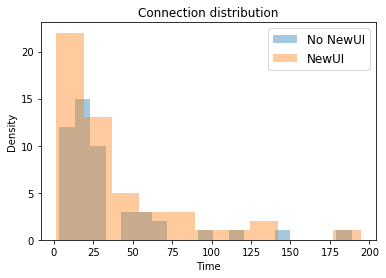

In [7]:
df_0 = df[df['newUI'] == 0]
sns.distplot(df_0['connection'],  kde=False, label='No NewUI')

df_1 = df[df['newUI'] == 1]
sns.distplot(df_1['connection'],  kde=False,label='NewUI')

plt.legend(prop={'size': 12})
plt.title('Connection distribution')
plt.xlabel('Time')
plt.ylabel('Density')

As we can see the shape is similar for both groups

Text(0, 0.5, 'Density')

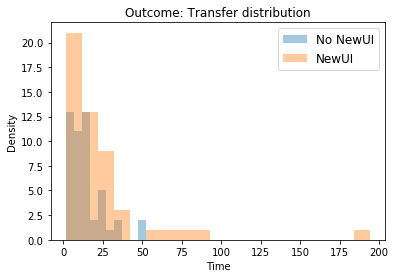

In [8]:
sns.distplot(df_0['transfer'],  kde=False, label='No NewUI')
sns.distplot(df_1['transfer'],  kde=False,label='NewUI')

plt.legend(prop={'size': 12})
plt.title('Outcome: Transfer distribution')
plt.xlabel('Time')
plt.ylabel('Density')

No handles with labels found to put in legend.


Text(0, 0.5, 'Count')

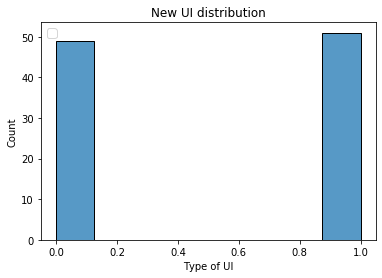

In [9]:
sns.histplot(data = df, x = "newUI")

plt.legend(prop={'size': 12})

plt.title('New UI distribution')

plt.xlabel('Type of UI')

plt.ylabel('Count')

In both cases, the variable connection and the dependent variable transfer are not normal distributed, so we will transform the variables to accomplish the assumptions and apply t-test to check if the difference in mean is statistically significant.

First I will use the log transformation and check the distributions.

In [10]:
df['connection_log'] = np.log(df['connection'])
df['transfer_log'] = np.log(df['transfer'])
df_0 = df[df['newUI'] == 0]
df_1 = df[df['newUI'] == 1]

C:\Users\ODIN\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

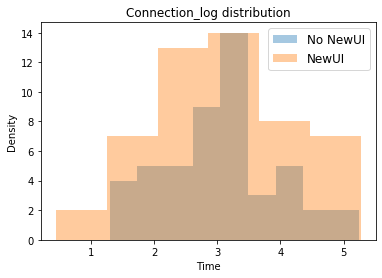

In [11]:
sns.distplot(df_0['connection_log'],  kde=False, label='No NewUI')
sns.distplot(df_1['connection_log'],  kde=False,label='NewUI')

plt.legend(prop={'size': 12})
plt.title('Connection_log distribution')
plt.xlabel('Time')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

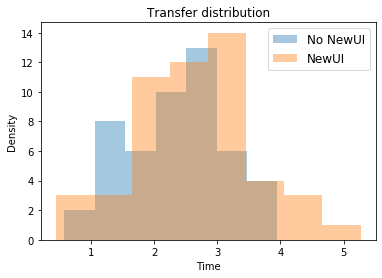

In [12]:
sns.distplot(df_0['transfer_log'],  kde=False, label='No NewUI')
sns.distplot(df_1['transfer_log'],  kde=False,label='NewUI')

plt.legend(prop={'size': 12})
plt.title('Transfer distribution')
plt.xlabel('Time')
plt.ylabel('Density')

voilà! it seem the distributions are normal using log transformation.

<a id="item2"></a>

### 2.- Checking the assumptions 

There are three asumption to be met to use t-test or regression, the assumptions are:
1. Are the two samples independent?
2. Are the data from each of the 2 groups following a normal distribution?
3. Do the two samples have the same variances (Homogeneity of Variance)?

if we fail, there are others test to analize the data.

In [22]:
# Calculating the mean for each groups
connection_0_mean = df_0['connection_log'].mean()
connection_1_mean = df_1['connection_log'].mean()
transfer_0_mean = df_0['transfer_log'].mean()
transfer_1_mean = df_1['transfer_log'].mean()
print('mean connection 0:',connection_0_mean)
print('mean connection 1:',connection_1_mean)
print('mean transfer 0:',transfer_0_mean)
print('mean transfer 1:',transfer_1_mean)
print('differece transfer means:',transfer_0_mean - transfer_1_mean)

mean connection 0: 3.0634413072659448
mean connection 1: 3.056230016547646
mean transfer 0: 2.3644256093707994
mean transfer 1: 2.7052214741969194
differece transfer means: -0.34079586482612


To be sure about the normality and homogeneity of Variances assumptions, we will perform the Shapiro test and Levene’s test

In [13]:
# More libraries
import scipy.stats as stats

In [14]:
stats.shapiro(df_0['transfer_log'].to_numpy())

ShapiroResult(statistic=0.9829994440078735, pvalue=0.6951248049736023)

In [15]:
stats.shapiro(df_1['transfer_log'].to_numpy())

ShapiroResult(statistic=0.9900442957878113, pvalue=0.943730890750885)

In [16]:
stats.levene(df_0['transfer_log'].to_numpy(), df_1['transfer_log'].to_numpy(), center='mean')

LeveneResult(statistic=1.0211352094172355, pvalue=0.3147383733854531)

As p-value in both cases of shapiro test p-value > 0.05, where 0.05 is the cut off, there is enough evidence to not reject the null hypothesis, so the distribution is normal. 
The levere test tell us if the variances are the same, since p-value is greater than 0.05, so the variances are not significatlly different.

<a id="item3"></a>

### 3.- Linear regression model

Following with the analysis, we will check if this difference in mean is for chance or statistically significant in dependent variable (transfer). We perform the t-test and see if it is worthy to continue.
To perform the t-test, we will use the libraries in scipy and statsmodels.

In [17]:
# More libraries
from scipy.stats import ttest_ind_from_stats
from statsmodels.stats.weightstats import ttest_ind
from scipy.special import stdtr

print("Libraries imported!!!")

Libraries imported!!!


In [18]:
# Use scipy.stats.ttest_ind_from_stats for connection.
t1, p1 = stats.ttest_ind(df_0['connection_log'], df_1['connection_log'], equal_var=True)
print("ttest_ind_from_stats for connection: t = %g  p = %g" % (t1, p1))

# Use scipy.stats.ttest_ind_from_stats for transfer.
t2, p2 = stats.ttest_ind(df_0['transfer_log'], df_1['transfer_log'], equal_var=True)
print("ttest_ind_from_stats for transfer: t = %g  p = %g" % (t2, p2))

ttest_ind_from_stats for connection: t = 0.035404  p = 0.97183
ttest_ind_from_stats for transfer: t = -1.97595  p = 0.0509721


Only the difference in transfer is statistically significant, this results are obvious considering the way that were generated the data.
Now using the ibrary statsmodel.

In [20]:
# Use ttest_ind from statsmodels.stats.weightstats

ttest_ind(df_0['connection_log'].to_numpy(), df_1['connection_log'].to_numpy(), alternative='two-sided')

(0.035404032236310515, 0.9718295834390247, 98.0)

In [21]:
ttest_ind(df_0['transfer_log'].to_numpy(), df_1['transfer_log'].to_numpy(), alternative='two-sided')

(-1.9759509171153988, 0.05097205205756319, 98.0)

As we can see, the results are the same using the two libraries. The difference in mean of the transfer is statistically significant, but don't in the connection variable.

Taking the data of the 100 users, we will stimate the effect by regressing the outcome of interest variable (log of transfer speed), since this variable transformation accomplish with all of the constraints to use the regression, and using the indicator (newUI). Randomization ensures that the coefficient of newUI is an unbiased estimate of the causal effect.

In [22]:
import statsmodels.formula.api as smf

print("Libraries Imported!!!")

Libraries Imported!!!


In [23]:
model = smf.ols('transfer_log ~ newUI', data=df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3644,0.123,19.197,0.000,2.120,2.609
newUI,0.3408,0.172,1.976,0.051,-0.001,0.683


Including in the model all variables, using log transformation.

In [24]:
model = smf.ols('transfer_log ~ newUI + connection_log', data=df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7267,0.226,3.220,0.002,0.279,1.175
newUI,0.3447,0.134,2.564,0.012,0.078,0.611
connection_log,0.5346,0.067,8.018,0.000,0.402,0.667


In [25]:
# getting the prediction of the model
ypred = model.fittedvalues
ypred

0     3.273557
1     2.889103
2     2.853740
3     3.528476
4     3.673529
        ...   
95    3.052836
96    2.680839
97    3.629891
98    2.398276
99    2.889994
Length: 100, dtype: float64

In [26]:
#Adding the prediction values to the dataframe
df['Transfer_log_pred'] = ypred.tolist()
df.head()

,newUI,connection,transfer,connection_log,transfer_log,Transfer_log_pred
0,0,117.22,5.85,4.764053,1.766442,3.273557
1,1,29.97,29.97,3.400197,3.400197,2.889103
2,0,53.45,7.36,3.978747,1.996060,2.853740
3,0,188.84,8.25,5.240900,2.110213,3.528476
4,1,130.00,28.35,4.867534,3.344627,3.673529


Comparing the values of coefficient for both models not change much, but the standard errors have decreased and the p-value is significantlly little.

Now to review the error, we will plot the residual.

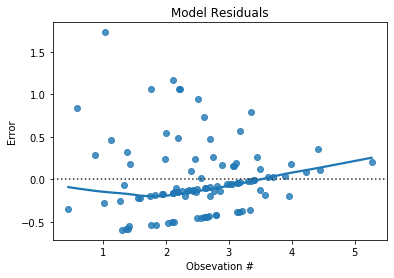

In [27]:
# To review the residual plot error between the predicted and the real values
sns.residplot(x = "transfer_log", y = "Transfer_log_pred", data = df, lowess = True)
plt.title('Model Residuals')
plt.xlabel('Obsevation #')
plt.ylabel('Error');

This plot show as the error is not homogenous, there are more errors in the little observations.

<a id="item4"></a>

### 4.- Random Forest model

The Random Forest is a algorithm that use bootstrap to test different subsets of the data, searching to reduce the error of the model. In the way that we will use the algorithm, we add a function that allow to define a set of parameters and the function automatically will get the best combination to fit with the data, hoping that the result will be better than Lineal Regression.

In [29]:
# Defining the x and y to use Random Forest
x = np.asarray(df[['newUI', 'connection_log']])
y = np.asarray(df[['transfer_log']])

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score,mean_squared_error

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

# Review the standard parametere
rfr = RandomForestRegressor(random_state = 42)
print(rfr.get_params())


# Use the random grid to search for best hyperparameters
rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 100, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1) # Fit the random search model
model_RFCR = rf_random.fit(x, y)

# To get the best parameters of the random forest
rf_random.best_params_

# Evaluating the base line with the best parameters found
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

# Random forest with the best parameters
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, x, y)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\ODIN\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Model Performance
Average Error: 0.8432 degrees.
Accuracy = 55.21%.


In [33]:
LR_R2 = r2_score(y,ypred)
LR_MSE = mean_squared_error(y,ypred)
print('The R-square for LR is: ', model.rsquared_adj)
print('The MSE for LR is: ', LR_MSE)
yp = best_random.predict(x)
RF_R2 = r2_score(y,yp)
RF_MSE = mean_squared_error(y,yp)
print('The R-square for RF is: ', RF_R2)
print('The MSE for RF is: ', RF_MSE)

The R-square for LR is:  0.4097084959328946
The MSE for LR is:  0.43812548494791065
The R-square for RF is:  0.7080475113808651
The MSE for RF is:  0.22116053168406904


The RF fitted better than LR, the relationship between the dependent variables and the independent variable are not lineal. Only the 41% of the variance of the dependent variable is explain by LR, while RF can explain 71%.

<a id="item5"></a>

### 5.- Conclusions

The A/B test is a helpfull tool to run experiments to decide the development to a campaing, products, retention policies, and of course decide if a tratment works or not. In our case we probe the difference of the transfer time is statistical significance, so the old and new UI conduct to the customers to get a different experience. But take care, the assumptions to perform the t-test must be met to get reliable results, if we fail to accomplished the test assumtions, the test to be perform is different and depent of the variables in the data.
In other hand, when we develop a model the relationship between variables is crucial, the performance of the model depent of it, as we saw in our example.